# Student Performance Microbenchmark
Simple statistical queries about students in a Portuguese class.
This file is adapted to use numpy only without Spark.

### Running PAC

In [1]:
from typing import Any, Callable, Dict, List, Tuple, Union

import numpy as np
import pandas as pd
from pandas import DataFrame
import concurrent.futures
import pyarrow as pa
import pyarrow.parquet as pq
import pickle

In [2]:
### Data Setup
por_df = pq.read_table(f"./data/student_performance/student-por.parquet").to_pandas()
por_df.shape

(649, 33)

In [3]:
### Query Setup
SAMPLES = 500

true_result = por_df['absences'].agg(['count','sum', 'mean', 'var']).to_numpy() # Save the true result of the query for later

def generate_samples() -> List[np.ndarray]:
    def run_query(i: int):
        temp_df = por_df.sample(frac=0.5)
        out_df = temp_df['absences'].agg(['count','sum', 'mean', 'var'])
        out_df['count'] *= 2
        out_df['sum'] *= 2
        return out_df.to_numpy()

    with concurrent.futures.ThreadPoolExecutor() as executor:
        out_np: List[np.ndarray] = list(executor.map(run_query, range(SAMPLES)))

    return out_np

In [4]:
GENERATE = False
if GENERATE:
    out_np = generate_samples()
else:
    print("GENERATE = False, so we will load saved output from files rather than recomputing.")

GENERATE = False, so we will load saved output from files rather than recomputing.


In [5]:
### Compute PAC Noise
def updateDataFrame(vec: np.ndarray, df: DataFrame) -> DataFrame:
    """
    Update a DataFrame with a noisy output vector.
    """
    noisy_output_df = df.copy()
    noisy_output_df.loc[0] = vec
    return noisy_output_df

def do_pac_and_release(out_np: List[np.ndarray], max_mi: float = 1./4) -> np.ndarray:
    dimensions: int = len(out_np[0])
    out_np_2darr = [np.atleast_2d(o) for o in out_np] # make sure all the DF -> np.ndarray conversions result in 2d arrays

    est_y: np.ndarray = np.stack(out_np_2darr, axis=-1).reshape(dimensions, SAMPLES)

    # get the variance in each basis direction
    fin_var: np.ndarray = np.var(est_y, axis=1)  # shape (dimensions,)
    sqrt_total_var: np.floating[Any] = np.sum(np.sqrt(fin_var))

    pac_noise: np.ndarray = (1./(2*max_mi)) * sqrt_total_var * np.sqrt(fin_var)  # variance of the PAC noise

    pac_noises_to_add: np.ndarray = np.random.normal(loc=0, scale=pac_noise)

    # Add noise element-wise to the outputs
    pac_release = out_np[0] + pac_noises_to_add

    return pac_release

# Update the DataFrame with the noisy output
# noisy_output_df = updateDataFrame(pac_release, out[0])

In [6]:
# If you want to see the output of one sample then run this
# do_pac_and_release(out_np)

To replicate the experiment that runs for epsilon=0.01, 0.1, 1, 10
we use mi=1, 1/4, 1/16, 1/64, 1/256 in the hopes of encompassing a similar range.

In [7]:
MI_OPTIONS = [16., 4., 2., 1., 1/4, 1/16, 1/64]
EXPERIMENTS = 500

if GENERATE:
    # df = pd.DataFrame([], columns=['mi', 'count', 'sum', 'mean', 'var'])
    experiment_results = []

    for e in range(EXPERIMENTS):
        for mi in MI_OPTIONS: 
            out_np = generate_samples()
            noisy_output = do_pac_and_release(out_np, mi)
            experiment_results.append([mi, *noisy_output])
    
    df = pd.DataFrame(experiment_results, columns=['mi', 'count', 'sum', 'mean', 'var'])
    
    # Save the new data to outputs/...
    # df.to_parquet('outputs/pac-results_student-por.parquet')
    # with open('outputs/pac-experiment_results_student-por.pkl', 'wb') as f:
    #     pickle.dump(experiment_results, f)
else:
    df = pq.read_table(f"outputs/pac-results_student-por.parquet").to_pandas()

    # Skip loading experiment_results because they are not needed, however you can load them if you want
    # with open('outputs/pac-experiment_results_student-por.pkl', 'rb') as f:
    #     experiment_results = pickle.load(f)

df.head()

,mi,count,sum,mean,var
0,16.00,648.0,3007.269320,3.454218,30.681478
1,4.00,648.0,4611.601458,6.223124,56.980608
2,2.00,648.0,3041.945306,-3.823065,23.998834
3,1.00,648.0,904.992937,1.628542,19.638230
4,0.25,648.0,-5254.929111,-36.296035,938.557493


### Computing PAC Errors

In [127]:
# functions to calculate errors
def absolute_scaled_error(est: np.ndarray, actual: np.ndarray) -> np.ndarray:
    return np.abs(est - actual)
def relative_error_percent(est: np.ndarray, actual: np.ndarray) -> np.ndarray:
    return (np.abs(est - actual) / actual) * 100

In [9]:
# compute errors for PAC (or import from saved file)
if GENERATE:
    errors_list = []
    for i, row in df.iterrows():
        mi = row['mi']
        r = row[['count', 'sum', 'mean', 'var']].to_numpy()
        errors_list.append([mi, *absolute_scaled_error(r, true_result), *relative_error_percent(r, true_result)])
    pac_errors_df = pd.DataFrame(errors_list, columns=['mi', 'absolute error count', 'absolute error sum', 'absolute error mean', 'absolute error var', 'relative error count', 'relative error sum', 'relative error mean', 'relative error var'])
    # pac_errors_df.to_parquet("outputs/pac-errors_student-por.parquet")  # overwrite saved
else:
    pac_errors_df = pq.read_table(f"outputs/pac-errors_student-por.parquet").to_pandas()
pac_errors_df

,mi,absolute error count,absolute error sum,absolute error mean,absolute error var,relative error count,relative error sum,relative error mean,relative error var
0,16.000000,1.0,632.269320,0.205258,9.144835,0.154083,26.621866,5.608939,42.461751
1,4.000000,1.0,2236.601458,2.563648,35.443966,0.154083,94.172693,70.055044,164.575171
2,2.000000,1.0,666.945306,7.482542,2.462191,0.154083,28.081908,204.470294,11.432568
3,1.000000,1.0,1470.007063,2.030934,1.898412,0.154083,61.895034,55.497938,8.814801
4,0.250000,1.0,7629.929111,39.955511,917.020850,0.154083,321.260173,1091.836924,4257.956448
...,...,...,...,...,...,...,...,...,...
3495,2.000000,1.0,1679.733034,1.844886,74.433423,0.154083,70.725601,50.413948,345.612942
3496,1.000000,1.0,310.578196,1.773411,254.824579,0.154083,13.076977,48.460784,1183.214055
3497,0.250000,1.0,17897.963749,27.051588,311.559321,0.154083,753.598474,739.220234,1446.647610
3498,0.062500,1.0,32788.122243,183.668797,593.745788,0.154083,1380.552515,5018.991548,2756.909732


In [10]:
# if GENERATE:
#     mean_df = df.groupby('mi').mean()[['count', 'sum', 'mean', 'var']]
#     std_df = df.groupby('mi').std()[['count', 'sum', 'mean', 'var']].abs()
#     mean_df, std_df

#     # save mean_df, std_df to parquet
#     mean_df.to_parquet('outputs/pac-mean_df_student-por.parquet')
#     std_df.to_parquet('outputs/pac-std_df_student-por.parquet')

### Analysis of PAC vs DP
- import the DP data
- create a dataframe (`all_df`) containing the query outputs
    - in this df, each output is the {mean, variance} aggregation over the 500 experiments, grouped by the type of privacy mechanism used (pac or dp) and privacy factor (mi or epsilon)
- create a dataframe in the same pattern containing the computed error for each privitized output

In [122]:
# Import Chai's saved data from running PipelineDP and use it to compare.
dp_results_df = pq.read_table(f"outputs/dp-results.parquet").to_pandas()
dp_errors_df = pq.read_table(f"outputs/dp-errors.parquet").to_pandas()

In [123]:
### Make one merged DF to compare results
all_df = pd.concat([  # we will call mi and epsilon the "factor" so that the schemas match
    dp_results_df.assign(type='dp').rename(columns={'eps': 'factor'}),
    df.assign(type='pac').rename(columns={'mi': 'factor'})
])
all_df = all_df.groupby(['type', 'factor']).agg(['mean', 'var'])
all_df.columns = [' '.join(col).strip() for col in all_df.columns.values]  # Flatten the columns
all_df

count mean   count var      sum mean       sum var  mean mean  \
type factor                                                                     
dp   0.200000          NaN         NaN           NaN           NaN        NaN   
     0.360000          NaN         NaN           NaN           NaN        NaN   
     0.400000          NaN         NaN           NaN           NaN        NaN   
     0.600000    27.012086         NaN -13934.758083           NaN        NaN   
     0.730000    29.864554  198.588455  57559.585589  7.859298e+08        NaN   
     0.800000    19.424820   14.530990  13444.677449  4.880396e+08        NaN   
     1.000000    22.782015   67.160321   1202.635907  7.386599e+08   0.055378   
     1.200000    23.820611   44.039598   -693.383649  4.179716e+08  -0.492588   
     1.400000    24.176187   38.140772   -638.337825  2.999726e+08  -0.717541   
     1.640000    23.880655   28.724803    495.535567  2.431191e+08  -0.125412   
     1.800000    24.175826   23.942971    129.990515  2.062910e+08   0.456100   
     2.000000    23.905020   20.857747    673.582050  1.607352e+08   0.661979   
     3.000000    24.197451    8.793445    225.977380  7.953828e+07   0.800454   
     4.000000    24.095631    4.879727   -266.678818  4.511043e+07   0.875129   
     5.000000    24.013572    3.235330    125.159179  3.359931e+07   0.965009   
     6.000000    24.061226    2.597636    -42.891428  2.361116e+07   1.000395   
     7.000000    23.955004    1.929674   -145.596364  1.616495e+07   0.977539   
     8.000000    24.007381    1.485909    -18.169597  1.417874e+07   0.972487   
     9.000000    24.018235    1.233782   -133.933115  1.086030e+07   0.989088   
     10.000000   24.007978    1.110470     33.680304  8.728696e+06   1.007524   
pac  0.015625   648.000000    0.000000  34337.897855  2.256472e+11 -34.953456   
     0.062500   648.000000    0.000000   6803.784139  1.281728e+10   4.677437   
     0.250000   648.000000    0.000000   2145.870583  8.092274e+08   0.846093   
     1.000000   648.000000    0.000000   2775.224748  5.515711e+07   3.773224   
     2.000000   648.000000    0.000000   2410.154614  1.354035e+07   3.710812   
     4.000000   648.000000    0.000000   2413.522609  3.300446e+06   3.775832   
     16.000000  648.000000    0.000000   2391.546190  2.320258e+05   3.687638   

                     mean var      var mean       var var  
type factor                                                
dp   0.200000             NaN           NaN           NaN  
     0.360000             NaN -1.628917e+04           NaN  
     0.400000             NaN  2.351314e+03           NaN  
     0.600000             NaN -1.069913e+06           NaN  
     0.730000             NaN -6.783881e+06  6.648767e+13  
     0.800000             NaN -1.735833e+06  7.699677e+12  
     1.000000             NaN -6.535972e+05  5.304606e+12  
     1.200000       30.881814 -3.789902e+05  1.871961e+12  
     1.400000       34.622510 -2.570506e+05  1.072120e+12  
     1.640000       15.758399 -1.621358e+05  6.486569e+11  
     1.800000        5.232873 -1.339149e+05  6.174577e+11  
     2.000000        4.683915 -8.537931e+04  1.981710e+11  
     3.000000        1.417389 -4.234022e+03  4.941188e+08  
     4.000000        0.925919 -7.834372e+02  2.651156e+07  
     5.000000        0.541989 -7.378738e+02  1.075401e+07  
     6.000000        0.390738 -2.386077e+02  2.787985e+06  
     7.000000        0.301863 -1.128724e+02  1.871567e+06  
     8.000000        0.230690 -1.670170e+02  1.399925e+06  
     9.000000        0.184164 -2.202679e+02  1.323995e+06  
     10.000000       0.138744 -8.705227e+01  8.381122e+05  
pac  0.015625   544741.648088 -1.757476e+02  7.720762e+07  
     0.062500    33134.999004 -1.010056e+02  5.970712e+06  
     0.250000     2207.222679  3.759898e+01  3.109707e+05  
     1.000000      117.208530  2.300922e+01  2.008155e+04  
     2.000000       30.447106  2.102166e+01  5.043350e+03  
     4.000000        7.480939  2.183050e+01  1

In [125]:
### Make another merged df for the errors
errors_df = pd.concat([  # we will call mi and epsilon the "factor" so that the schemas match
    dp_errors_df.assign(type='dp').rename(columns={'eps': 'factor'}), 
    pac_errors_df.assign(type='pac').rename(columns={'mi': 'factor'})
])
errors_df = errors_df.groupby(['type', 'factor']).agg(['mean', 'var'])
# drop absolute * mean and relative * var columns from level 1
errors_df = errors_df.drop(columns=[('absolute error count', 'mean'), ('absolute error sum', 'mean'), ('absolute error mean', 'mean'), ('absolute error var', 'mean'), ('relative error count', 'var'), ('relative error sum', 'var'), ('relative error mean', 'var'), ('relative error var', 'var')])
errors_df.columns = [' '.join(col).strip() for col in errors_df.columns.values]  # flatten the columns
errors_df

absolute error count var  absolute error sum var  \
type factor                                                        
dp   0.200000                        NaN                     NaN   
     0.360000                        NaN                     NaN   
     0.400000                        NaN                     NaN   
     0.600000                        NaN                     NaN   
     0.730000                 198.588455            7.859298e+08   
     0.800000                  14.530990            2.237735e+08   
     1.000000                  67.160321            2.228101e+08   
     1.200000                  44.039598            1.571997e+08   
     1.400000                  38.140772            1.149796e+08   
     1.640000                  28.724803            8.898952e+07   
     1.800000                  23.942971            7.903430e+07   
     2.000000                  20.857747            6.373527e+07   
     3.000000                   8.793445            3.001089e+07   
     4.000000                   4.879727            1.958923e+07   
     5.000000                   3.235330            1.521497e+07   
     6.000000                   2.597636            1.103846e+07   
     7.000000                   1.929674            8.083748e+06   
     8.000000                   1.485909            6.497140e+06   
     9.000000                   1.233782            5.893933e+06   
     10.000000                  1.110470            4.627719e+06   
pac  0.015625                   0.000000            8.456688e+10   
     0.062500                   0.000000            4.649321e+09   
     0.250000                   0.000000            3.043667e+08   
     1.000000                   0.000000            1.953585e+07   
     2.000000                   0.000000            4.933756e+06   
     4.000000                   0.000000            1.191089e+06   
     16.000000                  0.000000            8.192929e+04   

                absolute error mean var  absolute error var var  \
type factor                                                       
dp   0.200000                       NaN                     NaN   
     0.360000                       NaN                     NaN   
     0.400000                       NaN                     NaN   
     0.600000                       NaN                     NaN   
     0.730000                       NaN            6.648767e+13   
     0.800000                       NaN            7.692205e+12   
     1.000000                       NaN            5.300014e+12   
     1.200000                 29.451372            1.868708e+12   
     1.400000                 34.438801            1.068877e+12   
     1.640000                 15.452674            6.475880e+11   
     1.800000                  5.029797            6.166957e+11   
     2.000000                  4.464645            1.977192e+11   
     3.000000                  1.396439            4.771297e+08   
     4.000000                  0.925919            2.208267e+07   
     5.000000                  0.541989            7.895920e+06   
     6.000000                  0.390738            1.233272e+06   
     7.000000                  0.301863            8.467230e+05   
     8.000000                  0.230690            5.969314e+05   
     9.000000                  0.184164            5.757383e+05   
     10.000000                 0.138744            3.609700e+05   
pac  0.015625             204683.639452            2.818717e+07   
     0.062500              12784.193482            2.229957e+06   
     0.250000                744.354992            1.161025e+05   
     1.000000                 42.798268            7.187481e+03   
     2.000000                 10.918088            1.837038e+03   
     4.000000                  2.809700            4.672688e+02   
     16.000000                 0.203206            3.046103e+01   

                relative error count mean  relative error sum mean  \
type factor                  

In [14]:
#abs_error = errors_df.groupby('mi').mean()[['absolute error count', 'absolute error sum', 'absolute error mean', 'absolute error var']]
#rel_error = errors_df.groupby('mi').mean()[['relative error count', 'relative error sum', 'relative error mean', 'relative error var']]

#std_abs_error = errors_df.groupby('mi').std()[['absolute error count', 'absolute error sum', 'absolute error mean', 'absolute error var']]
#sample_mean_rel_error = errors_df.groupby('mi').mean()[['relative error count', 'relative error sum', 'relative error mean', 'relative error var']]

# save std_abs_error, sample_mean_rel_error to parquet
# std_abs_error.to_parquet('outputs/pac-std_abs_error_student-por.parquet')
# sample_mean_rel_error.to_parquet('outputs/pac-sample_mean_rel_error_student-por.parquet')

### Plotting Results

We are reproducing Table 14 from this paper: http://arxiv.org/abs/2109.10789

> TABLE 14: Experiments of the queries count, sum, mean, and var on the attribute Absences of the Portuguese education dataset containing 649 individuals (500 experiments per ε).

In [128]:
### Imports for matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

# Michael's matplotlib defaults
# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["mathtext.fontset"] = "stix"
    
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

In [145]:
PAC_COLOR = 'tab:blue'
DP_COLOR = 'tab:red'

# create legend, use color squares
from matplotlib.patches import Patch
pac_dp_legend_handles = [
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Patch(facecolor=DP_COLOR, edgecolor=DP_COLOR, label='DP')
]

Reproduction of Table 14 (PAC)

/var/folders/xy/7x33379123vd25mldyhv3q7m0000gn/T/ipykernel_13268/1866523705.py:20: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax1.set_yscale('log')


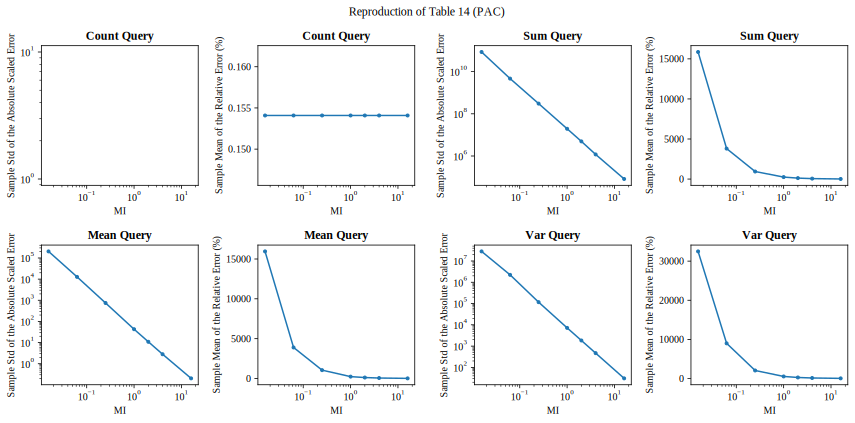

In [144]:
### Reproduction of Table 14 (PAC)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = ['count', 'sum', 'mean', 'var']

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    TYPE = 'pac'
    d = errors_df.loc[TYPE].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)
             #label=query, marker='.')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('MI')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc[TYPE].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)
    ax2.set_xscale('log')
    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('MI')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')

fig.suptitle("Reproduction of Table 14 (PAC)")
plt.tight_layout()
plt.show()

Reproduction of Table 14 (DP)

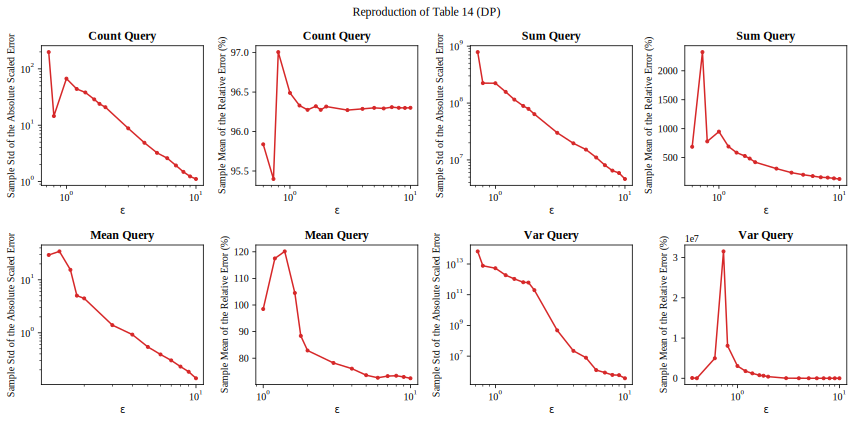

In [156]:
### Reproduction of Table 14 (DP)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = ['count', 'sum', 'mean', 'var']

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    TYPE = 'dp'
    d = errors_df.loc[TYPE].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=DP_COLOR)
             #label=query, marker='.')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('$\epsilon$')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc[TYPE].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=DP_COLOR)
    ax2.set_xscale('log')
    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('$\epsilon$')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')

fig.suptitle("Reproduction of Table 14 (DP)")
plt.tight_layout()
plt.show()

An attempt at putting both on the same axes, not aligned

/var/folders/xy/7x33379123vd25mldyhv3q7m0000gn/T/ipykernel_13268/3276319903.py:18: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax1.set_yscale('log')


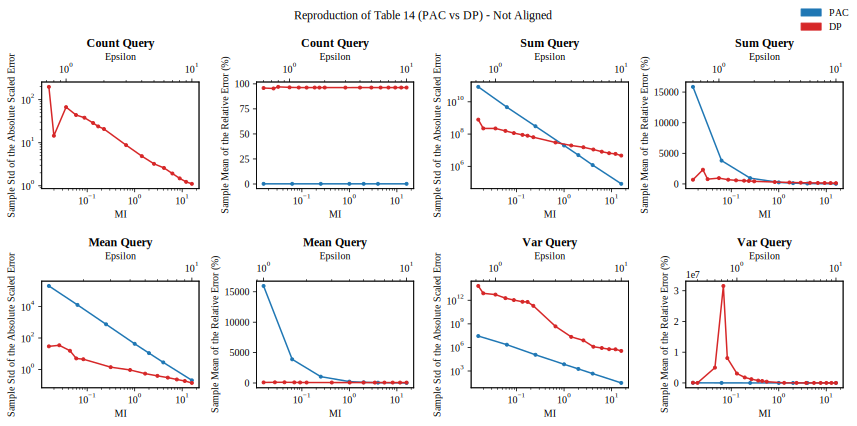

In [151]:
### An attempt at putting errors of both on the same axes, not aligned
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = ['count', 'sum', 'mean', 'var']

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    d = errors_df.loc['pac'].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('MI')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')

    ax1b = ax1.twiny()
    d = errors_df.loc['dp'].loc[:, f'absolute error {query} var']
    ax1b.plot(d.index, d, label=query, marker='.', color=DP_COLOR)
    ax1b.set_xscale('log')
    ax1b.set_xlabel('Epsilon')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc['pac'].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)
    ax2.set_xscale('log')
    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('MI')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')

    ax2b = ax2.twiny()
    d = errors_df.loc['dp'].loc[:, f'relative error {query} mean']
    ax2b.plot(d.index, d, label=query, marker='.', color=DP_COLOR)
    ax2b.set_xscale('log')
    ax2b.set_xlabel('Epsilon')

fig.legend(handles=pac_dp_legend_handles, loc='upper right', frameon=False)

fig.suptitle("Reproduction of Table 14 (PAC vs DP) - Not Aligned")
plt.tight_layout()
plt.show()

### Plotting the error for comparison

/var/folders/xy/7x33379123vd25mldyhv3q7m0000gn/T/ipykernel_13268/2735822799.py:7: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  to_plot = pac_errors_df.pivot_table(index='mi', aggfunc='mean')


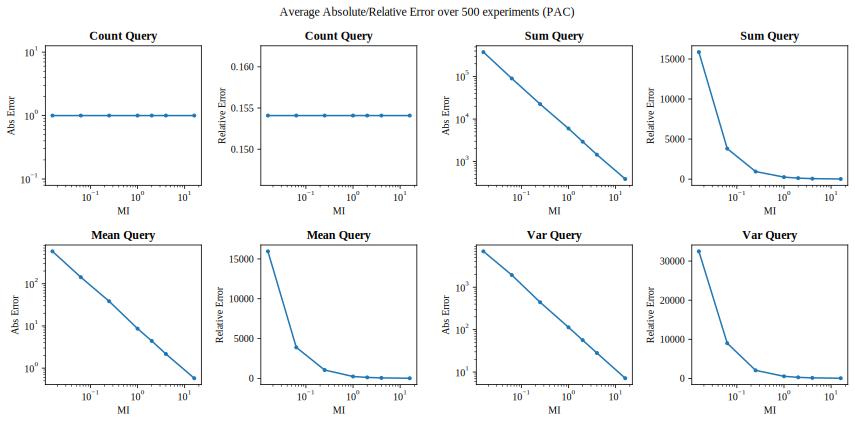

In [ ]:
### Average Absolute/Relative error over 500 experiments (PAC)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = ['count', 'sum', 'mean', 'var']

to_plot = pac_errors_df.pivot_table(index='mi', aggfunc='mean')  # create temporary df with aggregation to plot

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Absolute Scaled Error
    ax1.plot(to_plot.index, to_plot[f'absolute error {query}'], label=query, marker='.')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('MI')
    ax1.set_ylabel('Abs Error')

    # Plotting Relative Error (%)
    ax2.plot(to_plot.index, to_plot[f'relative error {query}'], label=query, marker='.')
    ax2.set_xscale('log')
    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('MI')
    ax2.set_ylabel('Relative Error')
    
del to_plot  # delete the temporary DataFrame

fig.suptitle("Average Absolute/Relative Error over 500 experiments (PAC)")
plt.tight_layout()
plt.show()

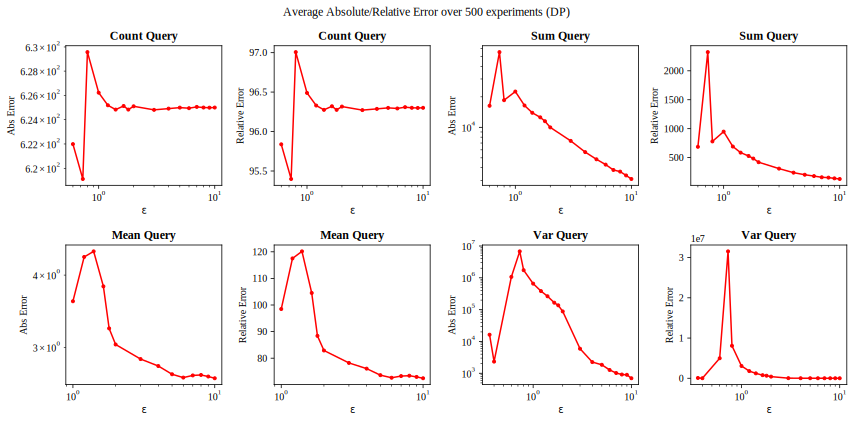

In [153]:
### Average Absolute/Relative error over 500 experiments (DP)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = ['count', 'sum', 'mean', 'var']

to_plot = dp_errors_df.pivot_table(index='eps', aggfunc='mean')  # create temporary df with aggregation to plot

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Absolute Scaled Error
    ax1.plot(to_plot.index, to_plot[f'absolute error {query}'], label=query, marker='.', color='red')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('$\epsilon$')
    ax1.set_ylabel('Abs Error')

    # Plotting Relative Error (%)
    ax2.plot(to_plot.index, to_plot[f'relative error {query}'], label=query, marker='.', color='red')
    ax2.set_xscale('log')
    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('$\epsilon$')
    ax2.set_ylabel('Relative Error')
    
del to_plot  # delete the temporary DataFrame

fig.suptitle("Average Absolute/Relative Error over 500 experiments (DP)")
plt.tight_layout()
plt.show()

In [ ]:
# Used to convert dp.csv to dp-results.parquet; no longer needed
if False:
    with open('dp.csv', 'r') as f:
        dp_results = pd.read_csv(f)
    # rename headings
    mapping = {
        "Epsilon": "epsilon",
        "Average Absolute Error over 500 Samples - Count": "absolute error count",
        "Average Relative Error over 500 Samples - Count": "relative error count",
        "Average Absolute Error over 500 Samples - Sum": "absolute error sum",
        "Average Relative Error over 500 Samples - Sum": "relative error sum",
        "Average Absolute Error over 500 Samples - Mean": "absolute error mean",
        "Average Relative Error over 500 Samples - Mean": "relative error mean",
        "Average Absolute Error over 500 Samples - Var": "absolute error var",
        "Average Relative Error over 500 Samples - Var": "relative error var",
    }
    dp_results = dp_results.rename(columns=mapping)
    dp_results